In [ ]:
#import libraries
import pandas as pd
import numpy as np
import csv
import ast
import re
from prettytable import PrettyTable

import time
import random

#data visualization libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.io as pio
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

#NLP & ML libraries
from gensim import corpora
from gensim.models import Word2Vec
from textblob import TextBlob
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from scipy.sparse import save_npz, load_npz


In [ ]:
#set seed so that code output is deterministic
random.seed(20)  # Set the seed for Python's random module
np.random.seed(20)  # Set the seed for NumPy's random module

In [ ]:
#import cleaned data

def list_converter(text):
    #to revert list->str conversion from pd.read_csv
    return ast.literal_eval(text)


data = pd.read_csv('Data/training_corpus.csv', converters ={'tokens':list_converter})

In [ ]:
data = data.drop(columns = ['index'])
print (data.shape)
data.head()

## **TFIDF MODEL**

In [ ]:
#convert df['tokens'] to list of strings for CountVectorizer
corpus = data['tokens'].apply(lambda token: ' '.join(token)).tolist()

corpus[:5]

#### **INSTANTIATE AND FIT TFIDF MODEL**

In [ ]:
start_time = time.time() #track start time of execution

#instantiate CountVectorizer
tfidf = TfidfVectorizer(ngram_range = (1,2))
   
#generate document vectors 
X_tfidf = tfidf.fit_transform(corpus)
print (f"The program took {time.time() - start_time:.2f} seconds to complete. The tfidf representation had {X_tfidf.shape[1]} features.")    

In [ ]:
#get feature names 
tfidf_features = tfidf.get_feature_names_out()
random.sample(set(tfidf_features), 5)

In [ ]:
#tabular presentation of a sample of the bag of words representation
text_df = data['clean_text'].loc[8000:8004].copy()
tfidf_df = pd.DataFrame(X_tfidf[8000:8005].toarray(), columns = tfidf_features)

text_tfidf = tfidf_df.copy()
text_tfidf = text_tfidf.loc[:, (text_tfidf > 0.0).any()] #show only columns with at least a 1 entry for any word

text_tfidf.insert(0, 'clean_text', text_df.values) #include column of pre-processed text

text_tfidf

In [ ]:
#visualize most common words in a wordcloud

#create tuple of word and a count of occurrence in whole corpus
word_scores = zip(tfidf_features, X_tfidf.sum(axis = 0).A1)

# Create a dictionary from the word_scores tuples
word_scores_dict = dict(word_scores)

#generate word cloud
wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_scores_dict)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

A look at the word cloud shows that the top commonly occuring words which need to be removed. It also shows the presence of informal words which add no information in our context, and as such should be removed as well. <br>We will redo the tfidf model, after removing these words from the corpus --> a sort of additional stop word removal

## **CUSTOM STOPWORD LIST**

In [ ]:
#find common and rare words using the frequency computed by the tfidf model
common = [word for word, freq in word_scores_dict.items() if freq >=300] #list of most common words
rare = [word for word, freq in word_scores_dict.items() if freq <=10] #list of rarely used words
other_words = [ #custom list of informal words carrying no meaning in our context
    "yeah", "okay", "ok", "lol", "omg", "brb", "btw", "imo", "imho", "ttyl", "idk", 
    "ikr", "smh", "np", "ty", "yw", "jk", "nvm", "tbh", "idc", "ily", "tmi", "wtf", 
    "wyd", "lmk", "atm", "fyi", "gtg", "g2g", "bff", "rofl", "stfu", "asap", 
    "post", "comment", "share", "like", "tweet", "follow", "update", "thread", 
    "dm", "pm", "status", "story", "tag", "meme", "emoji", "gif", "irl", "ama", 
    "tldr", "fomo", "yolo", "nsfw", "tbt", "q&a", "dms", "op", "subs", "mod", 
    "bot", "flair", "downvote", "upvote", "thread", "repost", "sidebar", "sticky", 
    "wiki", "karma", "gold", "throwaway", "username", "redditor", "crosspost", "redditor",
    "vote", "tl", "dr", "wow", "right", "sure", "definitely", "maybe", "know", "lately", 
    "probably", "r", "keep", "ae", "al", "kind", "oh", "wait", "stay", "shit", "old", "guess",
    "damn", "oh", "pretty", "hard", "reddit", "sub", "subreddit", "author", "previous", "got",
    "depend", "old", "nice", "cld", "pic", "bro", "shot", "photo", "oh", "question", "wish", "remember",
    "idea", "stuff", "fuck", "word", "second", "first", "third", "wrong", "easy", "week", "true",
    "believe", "literal", "literally", "haha", "hate", "move", "mind", "away", "yes", "big", 
    "problem", "happy", "high", "quality", "rate", "woman", "sorry", "happen", "feel", "guy", 
    "life", "try", "thank", "lot", "appreciate", "great", "help", "info", "information", "try",
    "bad", "feel", "world", "make", "lose", "love", "join", "place", "friend", "ask", "tell",
    "try", "live", "use", "hope", "soon", "let", "month", "talk", "help", "make", "different",
    "start", "issue", "mater", "hear", "leave", "actually", "person", "mention"
    "agree", "new", "though", "thought", "although", "send", "exact", "exactly", "man", "check",
    "number", "sound", "change", "close", "hour", "run", "video", "point", "wear", "wat", "far",
    "phone", "care", "understand", "kid", "dude", "reason", "ago", "speak", "miss", "free",
    "consider", "absolutely", "open", "situation", "edit", "open", "worth", "link", "watch", "video",
    "today", "head", "today", "honest", "honestly", "matter", "mention", "bit", "girl", "add", "amazing", 
    "picture", "little", "white", "able", "fact", "exist", "forget", "ah", "sense", "knowledge", "alright", 
    "group", "removal", "request", "view", "luck", "future", "buddy", "brother", "congratulation", "hey",
    "forgot", "otpion", "add", "list", "feedback", "savevideo", "video", "totally", "agree", "long", "end",
    "bit", "drop", "help", "helpful", "hand", "allow", "glad", "mate", "option", "help", "helpful", "reply",
    "instead", "save", "especially", "city", "fuck", "fucking", 'etc'
]
stopwords = list(set(common + rare + other_words))

In [ ]:
random.sample(stopwords, 10)

In [20]:
# Sort the keyword dictionary by values in descending order and get the first 50 items
top_50_words = sorted(word_scores_dict.items(), key=lambda x: x[1], reverse=True)[:50]

# Print the top 50 words and their frequencies
for word, freq in top_50_words:
    print(f'Word: {word}, Frequency: {freq}')

Word: like, Frequency: 863.138294948323
Word: people, Frequency: 861.7938798616043
Word: dubai, Frequency: 856.284555308504
Word: know, Frequency: 680.6222734607592
Word: good, Frequency: 670.8308587943704
Word: think, Frequency: 597.938150841331
Word: time, Frequency: 559.614028062269
Word: work, Frequency: 511.01536367873535
Word: go, Frequency: 510.0924210007593
Word: thank, Frequency: 483.43767648399336
Word: get, Frequency: 476.13872700458177
Word: need, Frequency: 468.34293343710084
Word: year, Frequency: 464.37002209305103
Word: look, Frequency: 463.2673750247626
Word: want, Frequency: 462.61030128313666
Word: day, Frequency: 443.98049214277705
Word: uae, Frequency: 438.21103552757154
Word: country, Frequency: 436.98044051892913
Word: thing, Frequency: 422.7711821613091
Word: pay, Frequency: 417.37631807035405
Word: way, Frequency: 409.49090759240323
Word: come, Frequency: 401.1931168940036
Word: say, Frequency: 397.59826965451686
Word: right, Frequency: 392.7433661770395
Word: 

#### **TFIDF MODEL with stop_words**

In [63]:
start_time = time.time() #track start time of execution

#instantiate CountVectorizer
tfidf = TfidfVectorizer(
                        ngram_range = (1,2),
                        token_pattern = r'(?u)\b\w\w+\b',
                       stop_words = stopwords,
                       )
   
#generate document vectors 
X_tfidf = tfidf.fit_transform(corpus)
print (f"The program took {time.time() - start_time:.2f} seconds to complete. The tfidf representation had {X_tfidf.shape[1]} features.")    

The program took 6.34 seconds to complete. The tfidf representation had 400244 features.


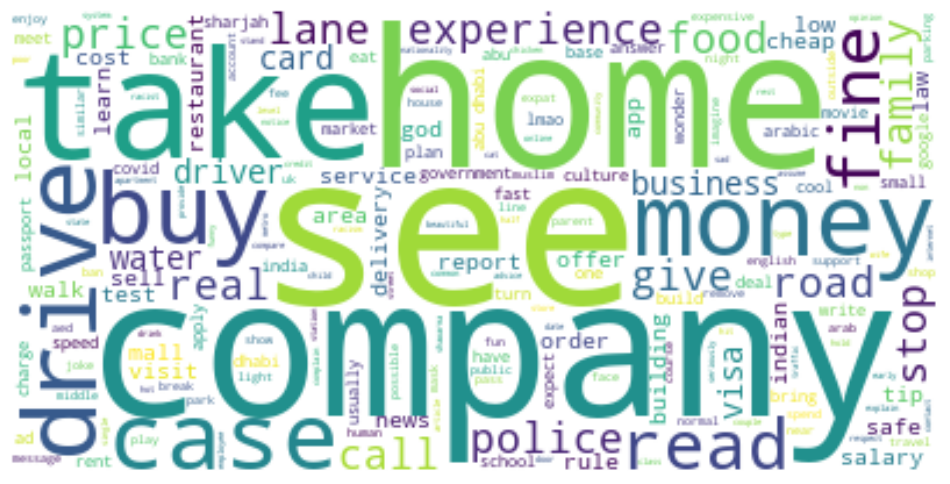

In [64]:
#visualize most common words in a wordcloud

tfidf_features = tfidf.get_feature_names_out()

#create tuple of word and a count of occurrence in whole corpus
word_scores = zip(tfidf_features, X_tfidf.sum(axis = 0).A1)

# Create a dictionary from the word_scores tuples
word_scores_dict = dict(word_scores)

#generate word cloud
wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_scores_dict)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
%%timeit

#determine optimum k-clusters
sse_metric = []
k_range = [5,8,10,12,15,18,20]#list(range(1,21))
sil_score = {}

for k in k_range:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', n_init = 10)#, batch_size = 5000)
    kmeans.fit(X_tfidf)
    sse_metric.append(kmeans.inertia_)
    
    if k > 1:
        score = silhouette_score(X_tfidf, kmeans.labels_)
        sil_score.update({f'{k} clusters':score})
    
    
#plot the elbow graph of the SSE values

plt.figure(figsize=(8,6))
plt.plot(k_range, sse_metric, '-*')
plt.xlabel('number of clusters')
plt.ylabel('inertia value')

plt.show()